Le Nutri-Score permet-il de mieux manger? 

Le Nutri-score est un système d'étiquetage nutritionnel à cinq niveaux, allant de A à E et du vert au rouge, placé sur le devant des emballages alimentaires, établi en fonction de la valeur nutritionnelle d'un produit alimentaire. Il a pour but d'aider les consommateurs à reconnaitre la qualité nutritionnelle globale des aliments et les aider à comparer les aliments entre eux, afin de favoriser le choix de produits plus favorable à la santé et ainsi de participer à la lutte contre les maladies chroniques comme les maladies cardiovasculaires, certains cancers, l'obésité et le diabète.

Nous souhaitons ici tenter de retrouver les principaux critères du Nutri-Score en regressant la valeur du nutri-score sur plusieurs variables qualitatives nutritionnelles. 
Puis nous aimerions élargir notre angle d'études en considérant d'autres critères pour quantifier la qualité d'un produit alimentaire (son niveau de transformation et sa provenance notamment). Nous crérons des scoring pour chacune des variables qu'on travaillerait. 
Enfin, nous aimerions mettre en évidence les différents catégories de produits alimentaires en utilisant des algorithmes de clustering à partir de nos scorings. 

Nous travaillerons sur la base de donnée OpenFoodFacts. Open Food Facts est un projet collaboratif dont le but est de constituer une base de données libre et ouverte sur les produits alimentaires commercialisés dans le monde entier. 
La première étape de notre projet est donc de nettoyer cette base de donnée très dense afin de pouvoir commencer nos analyses. 
Nous bornerons notre étude aux produits vendus en France, en ne gardant que les variables qui nous intéressent, pour cela on gardera les produits alimentaires qui auront toutes les variables d'intérêts renseignées.  

On importe les librairies Python qu'on utilisera dans le projet 

In [3]:
#On importe les modules nécessaires au traitement de la base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#On importe les modules qui seront utilisés lors de la modélisation
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


On importe la base de donnée OpenFoodFacts

In [4]:
# Charger le fichier CSV
url_path = 'https://www.data.gouv.fr/fr/datasets/r/164c9e57-32a7-4f5b-8891-26af10f91072'
# Charger le fichier CSV dans un DataFrame pandas
df_openfoodfacts = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


C:\Users\luneb\AppData\Local\Temp\ipykernel_6612\2182459212.py:4: DtypeWarning: Columns (0,9,10,12,13,14,15,21,22,23,24,25,29,30,31,32,33,34,35,42,44,45,46,49,50,51,54,65,70,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df_openfoodfacts = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


On veut connaître ses dimensions avant nettoyage

In [5]:
#On vérifie que la base est bien chargée
#on affiche 5 lignes aléatoires 
print(df_openfoodfacts.sample(5))

#on veut connaître la taille de la base
print ("Le dataframe compte {} lignes et {} variables".format(df_openfoodfacts.shape[0], df_openfoodfacts.shape[1]))


                  code                                                url  \
2387945       80003889  http://world-fr.openfoodfacts.org/produit/8000...   
1917685  4961115126800  http://world-fr.openfoodfacts.org/produit/4961...   
2927606  8850632202752  http://world-fr.openfoodfacts.org/produit/8850...   
2630743  8410199002303  http://world-fr.openfoodfacts.org/produit/8410...   
2459322  8005675013234  http://world-fr.openfoodfacts.org/produit/8005...   

           creator   created_t      created_datetime  last_modified_t  \
2387945    kiliweb  1640636228  2021-12-27T20:17:08Z       1693242231   
1917685  foodvisor  1654075833  2022-06-01T09:30:33Z       1654075833   
2927606        inf  1625341680  2021-07-03T19:48:00Z       1625341710   
2630743    kiliweb  1506280879  2017-09-24T19:21:19Z       1677840519   
2459322    kiliweb  1563821620  2019-07-22T18:53:40Z       1672244285   

        last_modified_datetime last_modified_by  \
2387945   2023-08-28T17:03:51Z       roboto-app

On commence le nettoyage de la base de donnée OpenFoodFacts: on ne garde que les produits français 

In [6]:
# Afficher les valeurs uniques de la colonne 'countries_tags' qui sera la variable sur laquelle on va faire un nettoyage 
valeurs_countries_tags = df_openfoodfacts['countries_tags'].unique()
# Afficher les valeurs
print(valeurs_countries_tags)

# Filtrer le DataFrame pour ne conserver que les lignes avec 'en:france' dans la colonne 'countries_tags'
df_france = df_openfoodfacts[df_openfoodfacts['countries_tags'] == 'en:france']
# Afficher les premières lignes du DataFrame résultant
print(df_france.head())

#on veut connaître la taille de la base
print ("Le dataframe compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))


['en:france' 'en:germany' 'en:spain' ...
 'en:algeria,en:egypt,en:malaysia,en:morocco,en:saudi-arabia,en:syria,en:tunisia'
 'en:bolivia,en:ireland,en:united-states'
 'en:bulgaria,en:cyprus,en:czech-republic,en:greece']
                    code                                                url  \
0      00000000000000225  http://world-fr.openfoodfacts.org/produit/0000...   
3   00000000000026772226  http://world-fr.openfoodfacts.org/produit/0000...   
4          0000000000017  http://world-fr.openfoodfacts.org/produit/0000...   
5          0000000000031  http://world-fr.openfoodfacts.org/produit/0000...   
11         0000000000100  http://world-fr.openfoodfacts.org/produit/0000...   

           creator   created_t      created_datetime  last_modified_t  \
0   nutrinet-sante  1623855208  2021-06-16T14:53:28Z       1692101569   
3          kiliweb  1654250311  2022-06-03T09:58:31Z       1654270474   
4          kiliweb  1529059080  2018-06-15T10:38:00Z       1561463718   
5         isag

On souhaite visualiser d'un coup d'oeil les variables d'intérêt de la base de donnée: quelles variables pourrons nous être utiles pour notre analyse? lesquelles sont assez remplies pour nous être utiles? 

C:\Users\luneb\AppData\Local\Temp\ipykernel_6612\2740516386.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


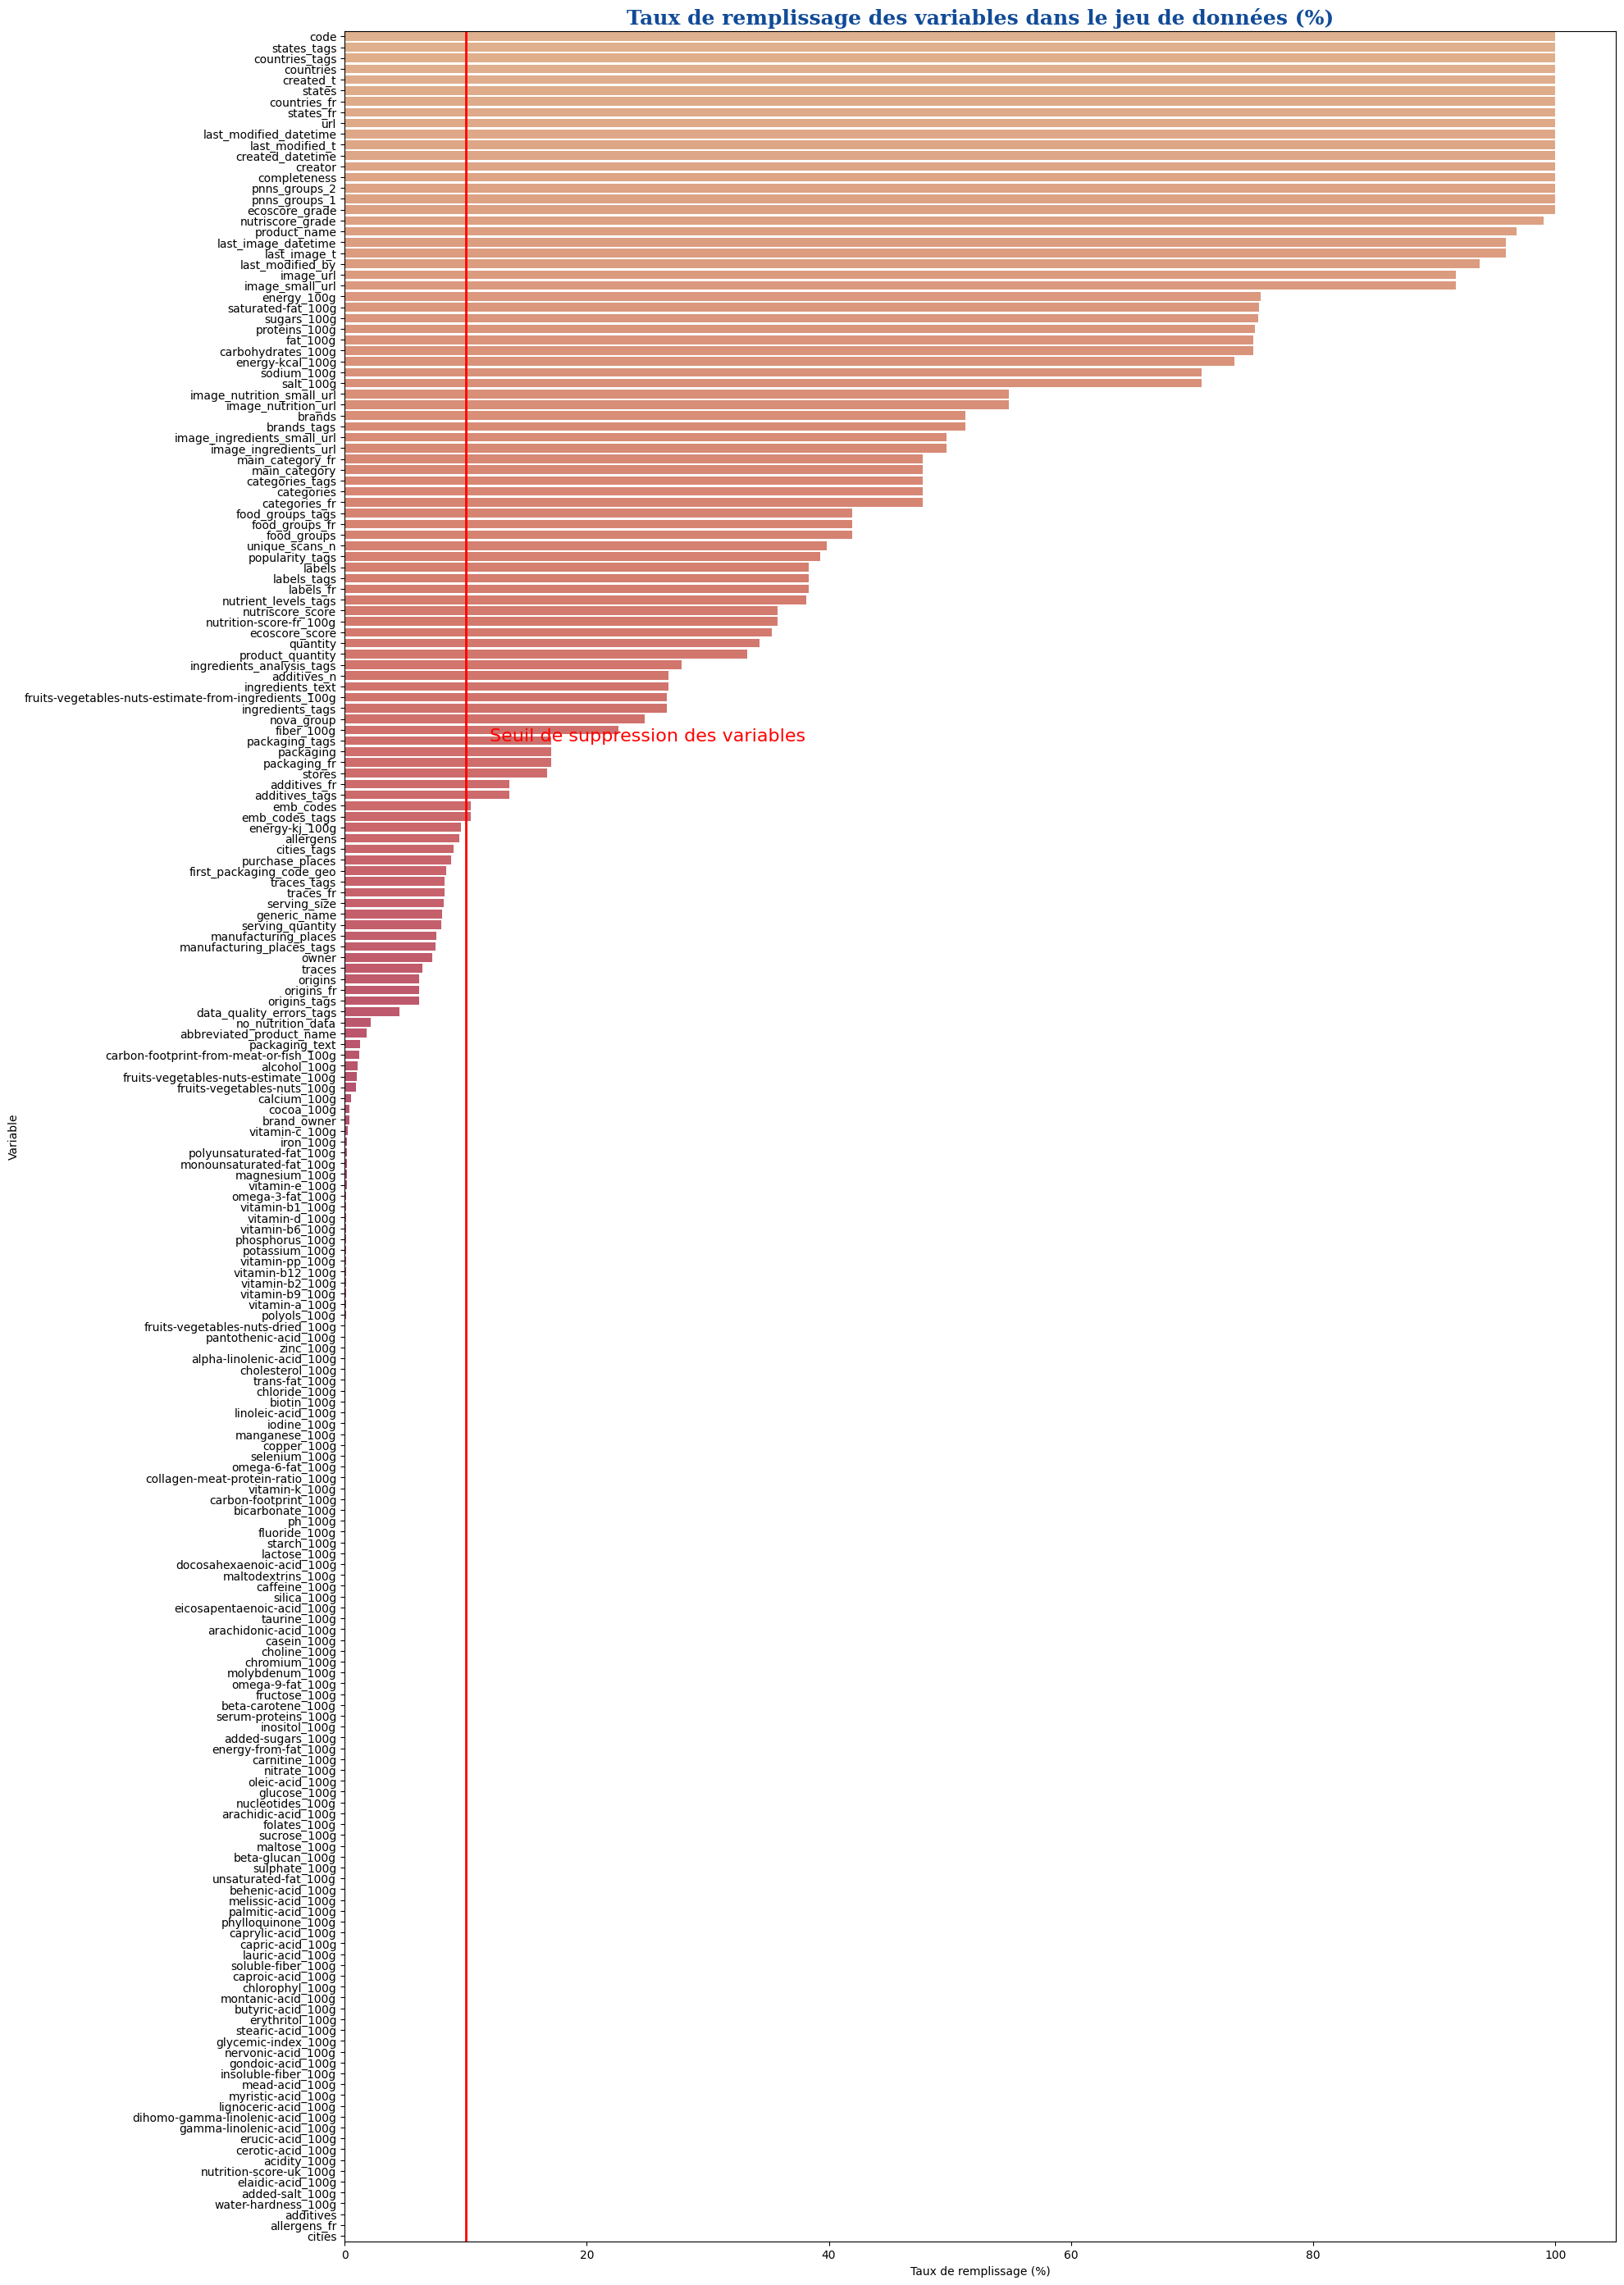

In [7]:
#On calcule le taux de remplissage de chaque variable
def null_factor(df):
  null_rate = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  return null_rate

#Nous alllons désormais commencer à nettoyer la base de données en enlevant les colonnes peu remplis. 
filling_features = null_factor(df_france)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 10

#On affiche le taux de remplissages des variables en fonction d'un seuil de référence
fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

On va supprimer les colonnes qui ne sont pas remplies à + de 10% 

In [8]:
#On ne décide de ne garder que les colonnes remplis à plus de 25%
seuil = 10  
filled_variables = list(filling_features.loc[filling_features['Taux_de_Null'] >= seuil, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
df_cleaned = df_france[filled_variables]

# Affichage du résultat
print ("Le dataframe df_cleaned compte {} lignes et {} variables".format(df_cleaned.shape[0], df_cleaned.shape[1]))

for column_name in df_cleaned.columns:
    print(column_name)

Le dataframe df_cleaned compte 924663 lignes et 73 variables
code
states_tags
countries_tags
countries
created_t
states
countries_fr
states_fr
url
last_modified_datetime
last_modified_t
created_datetime
creator
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
last_image_datetime
last_image_t
last_modified_by
image_url
image_small_url
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
fat_100g
carbohydrates_100g
energy-kcal_100g
sodium_100g
salt_100g
image_nutrition_small_url
image_nutrition_url
brands
brands_tags
image_ingredients_small_url
image_ingredients_url
main_category_fr
main_category
categories_tags
categories
categories_fr
food_groups_tags
food_groups_fr
food_groups
unique_scans_n
popularity_tags
labels
labels_tags
labels_fr
nutrient_levels_tags
nutriscore_score
nutrition-score-fr_100g
ecoscore_score
quantity
product_quantity
ingredients_analysis_tags
additives_n
ingredients_text
fruits-vegetables-nuts-estimate-from-ingredients_100g


On allège de nouveau la base de donnée en enlevant les variables qui ne nous intéresse pas pour la suite (celles qui contiennent des images des produits notamment par exemple et qui consomment beaucoup de place)

In [9]:
#On supprime les variables inutiles pour le reste du projet pour alléger la base
useless_columns = [col for col in df_cleaned.columns if 'url' in col or 'image' in col or "categories" in col or "last" in col or "states" in col or "creator" in col ]
df_cleaned = df_cleaned.drop(columns=useless_columns)

print ("Le dataframe df_cleaned compte {} lignes et {} variables".format(df_cleaned.shape[0], df_cleaned.shape[1]))

#On affiche le nom des colonnes restantes
for column_name in df_cleaned.columns:
    print(column_name)


Le dataframe df_cleaned compte 924663 lignes et 54 variables
code
countries_tags
countries
created_t
countries_fr
created_datetime
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
fat_100g
carbohydrates_100g
energy-kcal_100g
sodium_100g
salt_100g
brands
brands_tags
main_category_fr
main_category
food_groups_tags
food_groups_fr
food_groups
unique_scans_n
popularity_tags
labels
labels_tags
labels_fr
nutrient_levels_tags
nutriscore_score
nutrition-score-fr_100g
ecoscore_score
quantity
product_quantity
ingredients_analysis_tags
additives_n
ingredients_text
fruits-vegetables-nuts-estimate-from-ingredients_100g
ingredients_tags
nova_group
fiber_100g
packaging_tags
packaging
packaging_fr
stores
additives_fr
additives_tags
emb_codes
emb_codes_tags


A partir de cette liste, en modifiant à la main, on va garder uniquement les variables que je souhaite étudier pour la suite. 

On va désormais élargir notre analyse en prenant en compte de nouveaux critères qui sont importants lorsqu'on souhaite mieux s'alimenter: le degré de transformation, les additifs et la provenance des produits. On va essayer de créé des variables de scoring pour ces trois catégories avant de faire une comparaison avec le Nutri-Score étudié au dessus. 

1. Analyse du degré de transformation

Pour cette variable, le principal problème est la quantification de la transformation du produit alimentaire. Une approche simple serait de considérer que plus un produit alimentaire contient d'ingrédient, plus il est transformé. 

En s'appuyant sur les critères du nova-score, on va essayer de reproduire son scoring en appliquant les critères décrits ici: https://scanup.fr/degre-de-transformation-des-aliments-la-classification-nova/ .

D'abord, on va donc identifier les produits de la base qui correspondent à des produits naturels (fruits, légumes, poisson qui sont tels quels) en utilisant la catégorie food_groups_tags, avant de faire une analyse des ingrédients sur les produits qu'on identifie comme étant non bruts. 
On observe sur le graphique généré précédemment qu'environ 40% des produits ont la variable food_groups_tags renseigné, ce qui nous permettra de générer un nova score sur environ 40% des produits de la base. 

In [10]:
# Afficher les valeurs uniques de la colonne 'main_category_fr'
valeurs_main_category_fr = df_cleaned['food_groups_tags'].unique()

# Afficher les valeurs
print(valeurs_main_category_fr)


['en:fruits-and-vegetables,en:vegetables'
 'en:milk-and-dairy-products,en:dairy-desserts' nan
 'en:fats-and-sauces,en:dressings-and-sauces'
 'en:beverages,en:fruit-juices' 'en:sugary-snacks,en:sweets'
 'en:composite-foods,en:one-dish-meals'
 'en:composite-foods,en:pizza-pies-and-quiches'
 'en:fruits-and-vegetables,en:fruits'
 'en:fish-meat-eggs,en:meat,en:poultry'
 'en:beverages,en:sweetened-beverages'
 'en:milk-and-dairy-products,en:cheese' 'en:cereals-and-potatoes,en:bread'
 'en:fish-meat-eggs,en:fish-and-seafood,en:fatty-fish'
 'en:cereals-and-potatoes,en:legumes'
 'en:fish-meat-eggs,en:meat,en:meat-other-than-poultry'
 'en:sugary-snacks,en:biscuits-and-cakes'
 'en:salty-snacks,en:salty-and-fatty-products'
 'en:fruits-and-vegetables,en:dried-fruits' 'en:fats-and-sauces,en:fats'
 'en:cereals-and-potatoes' 'en:beverages,en:unsweetened-beverages'
 'en:cereals-and-potatoes,en:cereals' 'en:alcoholic-beverages'
 'en:salty-snacks,en:nuts' 'en:salty-snacks,en:appetizers'
 'en:sugary-snacks,

On fait un premier test de scoring en prenant en compte uniquement le nombre d'ingédient listé dans le produit. S'il y en a qu'un, on le marque comme étant produit brut, c'est-à-dire 1. S'il y en à 2 ou 3, on peut le catégorisé comme étant produit culinaire, avec lesquels on peut faire du fait maison (huile, conserves, yaourt). Entre 4 et 6 ingédients, on considèrera que c'est des produits simplement transformés. Au delà, on les considèrera comme des ingédiants ultra-transformé. Selon le graphique, on devrait avoir environ 30% de  produits renseignés. 

In [13]:
# Afficher les valeurs uniques de la colonne 'main_category_fr'
valeurs_main_category_fr = df_cleaned['ingredients_text'].unique()

# Afficher les valeurs
print(valeurs_main_category_fr)


[nan
 'eau graines de téguments de moutarde vinaigre de vin rouge sel vin rouge sucre   moût de raisin (6.2%) oignons colorants extraits de carotte et extrait de paprika huile de tournesol son de moutarde sel (cette _moutarde_ uniquement disponible chez courte paille)'
 "antioxydant : érythorbate de sodium, colorant : caramel - origine UE), tomate 33,3%, MAYONNAISE 11,1% (huile de colza 78,9%, eau, jaunes d'OEUF 6%, vinaigre, MOUTARDE [eau, graines de MOUTARDE, sel, vinaigre, curcuma], sel, dextrose, stabilisateur : gomme de cellulose, conservateur : sorbate de potassium, colorant : ?-carotène, arôme)"
 ...
 "KABANOSÈRÇ Sktadn' wiep -zEkrobia, Guszcz 'o.eprzowy, sél,przyprawy, ekstrakty cukii, , askorbinian sodu, substancja konserwujaca:azotyn afginian SOdu• stabilizatory: celuloza, Chlorek wapnia. Produkt moie zawierae"
 "MATIÈRE GRASSE DU LAIT BABEURRE (34%), FARINE DE 9x15g=135g FROMENT, FARINE PRÉGÉLATINISÉE DE BLÉ, matière grasse de palme, sucre, AMIDON DE BLÉ, POUDRE D'OEUFS ENTI

On voit que le renseignement de la variable ingredients_text est assez hétérogène: on considère donc 2 approches. Une première qui consiste à compter le nombre de virgule et une deuxième qui consiste à compter le nombre d'espaces lorsqu'il n'y a aucune virgule dans la chaîne de caractère et de considérer le quotient de la division euclidienne par 2 (en estimant que pour un ingrédients, on fait 2 espaces). Ca ne nous donnera pas le nombre exact d'ingrédients mais ça nous donnera quand même une bonne idée. 

In [28]:
# Assurez-vous que 'ingredients_text' ne contient pas de valeurs nulles
df_cleaned_nova = df_cleaned.dropna(subset=['ingredients_text'])

# Compter le nombre d'espaces dans chaque chaîne de caractères de 'ingredients_text'
df_cleaned_nova['nombre_ingredients'] = df_cleaned_nova['ingredients_text'].apply(lambda x: x.count(' '))

# Afficher le DataFrame avec la nouvelle colonne
print(df_cleaned_nova[['ingredients_text', 'nombre_ingredients']])

# Obtenir un tableau d'occurrences du nombre d'ingrédients
occurrences_nb_ingredients = df_cleaned_nova['nombre_ingredients'].value_counts()

# Afficher le tableau d'occurrences
print(occurrences_nb_ingredients)

                                          ingredients_text  nombre_ingredients
11       eau graines de téguments de moutarde vinaigre ...                  42
33       antioxydant : érythorbate de sodium, colorant ...                  47
41       Lait entier, sucre, amidon de maïs, cacao, Aga...                   8
50       baguette Poite vin Pain baguette 50,6%: farine...                  50
64       Paln suédois 42,6%: farine de BLÉ, eau, farine...                  55
...                                                    ...                 ...
3035980  sucre,beurre de cacao,poudre de jait.entier,fa...                  32
3035999  BIOCOOP BORDEAUX LAC distribue par les eleveur...                  35
3036008  KABANOSÈRÇ Sktadn' wiep -zEkrobia, Guszcz 'o.e...                  22
3036073  MATIÈRE GRASSE DU LAIT BABEURRE (34%), FARINE ...                  80
3036077  VIANDE HACHEE PUR BOEUF 5% M,G, POURCENTAGE DE...                  22

[247265 rows x 2 columns]
nombre_ingredients
0     

C:\Users\luneb\AppData\Local\Temp\ipykernel_6612\3130484556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_nova['nombre_ingredients'] = df_cleaned_nova['ingredients_text'].apply(lambda x: x.count(' '))


On va établir le scoring suivant: 
- produit brut: 1 si le nombre d'ingrédients est égal à 1 ou 2; 
- ingrédient culiaire: 2 si le nom d'ingrédients est 3 ou 4; 
- produit simplement transformé: 3 si le nombre d'ingrédiants est situé entre 5 et 7 et 
- produit très transformé: 4 si le nombre d'ingrédients est au delà de 8. 

In [29]:
# Créer une nouvelle colonne 'score' en fonction du nombre d'ingrédients
df_cleaned_nova['score_transformation'] = df_cleaned_nova['nombre_ingredients'].apply(lambda n: 1 if n <= 2 else (2 if n <= 4 else (3 if n <= 7 else 4)))

# Afficher le DataFrame avec la nouvelle colonne 'score'
#print(df_cleaned_nova[['ingredients_text', 'nombre_ingredients', 'score_transformation']])

# Obtenir un tableau d'occurrences du scoring sur la transformation des produits
occurrences_scoring_transformation = df_cleaned_nova['score_transformation'].value_counts()

# Afficher le tableau d'occurrences
print(occurrences_scoring_transformation)


score_transformation
4    198892
1     20627
3     16310
2     11436
Name: count, dtype: int64


C:\Users\luneb\AppData\Local\Temp\ipykernel_6612\3631206017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_nova['score_transformation'] = df_cleaned_nova['nombre_ingredients'].apply(lambda n: 1 if n <= 2 else (2 if n <= 4 else (3 if n <= 7 else 4)))


Pour tester le scoring qu'on vient de créer, nous proposons de regarder les occurences de food_groups_tags qu'on retrouve parmi les produits qu'on a classé en scoring 1 pour la transformation pour voir s'il y a une certaine cohérence (nous ne sommes pas censé retrouver des buscuits par exemple)

In [32]:
# Filtrer les produits avec un score de 1
score_1_products = df_cleaned_nova[df_cleaned_nova['score_transformation'] == 1]

# Afficher les occurrences de food_groups_tags pour les produits avec un score de 1
occurrences_score_1 = score_1_products['food_groups_tags'].value_counts()

# Afficher les résultats
print(occurrences_score_1)


food_groups_tags
en:fruits-and-vegetables,en:vegetables                  1887
en:alcoholic-beverages                                  1679
en:beverages,en:unsweetened-beverages                   1564
en:cereals-and-potatoes,en:cereals                      1308
en:sugary-snacks,en:sweets                              1263
en:fish-meat-eggs,en:meat,en:poultry                    1213
en:fruits-and-vegetables,en:fruits                      1133
en:fish-meat-eggs,en:meat,en:meat-other-than-poultry    1025
en:salty-snacks,en:nuts                                  617
en:cereals-and-potatoes,en:legumes                       548
en:fats-and-sauces,en:fats                               546
en:fish-meat-eggs,en:eggs                                487
en:fruits-and-vegetables,en:dried-fruits                 475
en:fish-meat-eggs,en:fish-and-seafood,en:fatty-fish      378
en:milk-and-dairy-products,en:milk-and-yogurt            357
en:milk-and-dairy-products,en:cheese                     251
en:fish

On va vérifier les occurences étranges et voir ce qu'ob peut faire pour corriger ces défauts 

In [33]:
# Filtrer les produits où food_groups_tags prend la valeur "en:sugary-snacks,en:biscuits-and-cakes"
filtered_products = score_1_products[score_1_products['food_groups_tags'] == 'en:sugary-snacks,en:biscuits-and-cakes']

# Afficher la colonne 'product_name' des produits filtrés
print(filtered_products[['product_name', 'ingredients_text']])


                                              product_name  \
191859                                     Rainbow Cookies   
805698                                   Quest Bar Smore´s   
836360                 Langue De Chat PAD*2 VBF S/V ~1,2kg   
1118085                     Flan patissier vanille bourbon   
1144115                                    Meringue Nature   
1161143                                      Babas au Rhum   
1171731                         Macaron coffret collection   
1203711                                        Creamy choc   
1213188                              Pain d'épices au miel   
1214154                  Madeleines longues aux œufs frais   
1232751                              Pain d'épices au miel   
1239590     Muffins parfum Vanille aux pépites de chocolat   
1258128                      Biscuits fourres gout vanille   
1271882                         Éclats de Meringue Crumble   
1271883                                 Éclats de Meringue   
1299639 